In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
import itertools
import random
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import torch.nn.utils.prune as prune
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import logging
from functools import partial
from collections import OrderedDict
import seaborn as sns
import matplotlib as mp
import time
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import umap.umap_ as umap

In [29]:
gene_data = pd.read_csv('/Users/solomon/Desktop/BRCA/BRCA_mRNA.csv')
gene_data = gene_data.drop(gene_data.columns[[0]], axis=1)
gene_data = gene_data.T
gene_feature_num = gene_data.shape[1]
data_num = gene_data.shape[0]
gene_data = gene_data.values.reshape(-1,1,gene_feature_num)
print('gene_data:',gene_data.shape)

gene_data: (671, 1, 18206)


In [30]:
genomics_data = pd.read_csv('/Users/solomon/Desktop/BRCA/BRCA_CNV.csv')
genomics_data = genomics_data.drop(genomics_data.columns[[0]], axis=1)
genomics_data = genomics_data.T
genomics_feature_num = genomics_data.shape[1]
data_num = genomics_data.shape[0]
genomics_data = genomics_data.values.reshape(-1,1,genomics_feature_num)
print('genomics_data:',genomics_data.shape)

genomics_data: (671, 1, 19568)


In [31]:
epigenomics_data = pd.read_csv('/Users/solomon/Desktop/BRCA/BRCA_Methy.csv')
epigenomics_data = epigenomics_data.drop(epigenomics_data.columns[[0]], axis=1)
epigenomics_data = epigenomics_data.T
epigenomics_feature_num = epigenomics_data.shape[1]
data_num = epigenomics_data.shape[0]
epigenomics_data = epigenomics_data.values.reshape(-1,1,epigenomics_feature_num)
print('epigenomics_data:',epigenomics_data.shape)

epigenomics_data: (671, 1, 19049)


In [32]:
mir_data = pd.read_csv('/Users/solomon/Desktop/BRCA/BRCA_miRNA.csv')
mir_data = mir_data.drop(mir_data.columns[[0]], axis=1)
mir_data = mir_data.T
mir_feature_num = mir_data.shape[1]
data_num = mir_data.shape[0]
mir_data = mir_data.values.reshape(-1,1,mir_feature_num)
print('mir_data:',mir_data.shape)

mir_data: (671, 1, 368)


In [34]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data_1, data_2, data_3, data_4):

        self.data_1 = data_1
        self.data_2 = data_2
        self.data_3 = data_3
        self.data_4 = data_4
        self.datanum = len(data_1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data = torch.tensor(self.data_1[idx]).float() 
        out_data_2 = torch.tensor(self.data_2[idx]).float()
        out_data_3 = torch.tensor(self.data_3[idx]).float()
        out_data_4 = torch.tensor(self.data_4[idx]).float()

        return out_data, out_data_2, out_data_3, out_data_4

In [35]:
train_gene, test_gene = train_test_split(gene_data, test_size = 0.2)
print('train_gene_data:',len(train_gene))
print('test_gene_data:',len(test_gene))

train_genomics, test_genomics = train_test_split(genomics_data, test_size = 0.2)
print('train_genomics_data:',len(train_genomics))
print('test_genomics_data:',len(test_genomics))

train_epi, test_epi = train_test_split(epigenomics_data, test_size = 0.2)
print('train_epi_data:',len(train_epi))
print('test_epi_data:',len(test_epi))

train_mir, test_mir = train_test_split(mir_data, test_size = 0.2)
print('train_mir_data:',len(train_mir))
print('test_mir_data:',len(test_mir))

train_data_set = Mydatasets(data_1 = train_gene, data_2 = train_genomics, data_3 = train_epi, data_4 = train_mir)
test_data_set = Mydatasets(data_1 = test_gene, data_2 = test_genomics, data_3 = test_epi, data_4 = test_mir)

train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 32, shuffle=False)

train_gene_data: 536
test_gene_data: 135
train_genomics_data: 536
test_genomics_data: 135
train_epi_data: 536
test_epi_data: 135
train_mir_data: 536
test_mir_data: 135


In [36]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = rearrange(inputs, 'b c l -> b l c')
        inputs = inputs.contiguous()
        #inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        quantized = rearrange(quantized, 'b c l -> b l c')
        quantized = quantized.contiguous()
        
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
        return loss, quantized, perplexity, encodings
    
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = rearrange(inputs, 'b c l -> b l c')
        inputs = inputs.contiguous()
        #inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        quantized = rearrange(quantized, 'b c l -> b l c')
        quantized = quantized.contiguous()
        
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
               
        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
        return loss, quantized, perplexity, encodings   

In [37]:
class ResidualStack(nn.Module):
    def __init__(self, encoder_dim):
        super(ResidualStack, self).__init__()
        
        self.block = nn.Sequential(
            nn.Linear(encoder_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, encoder_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return x + self.block(x)
    
class Encoder(nn.Module):
    def __init__(self, input_size, encoder_dim, dropout):
        super(Encoder, self).__init__()

        self.lay1 = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.lay2 = nn.Sequential(
            nn.Linear(128, encoder_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self._residual_stack = ResidualStack(encoder_dim)

    def forward(self, inputs):
        x = self.lay1(inputs)
        x = self.lay2(x)        
        x = self._residual_stack(x)
        return x 

class Decoder(nn.Module):
    def __init__(self, num_embeddings, input_size, encoder_dim, dropout):
        super(Decoder, self).__init__()
        
        self.lay0 = nn.Sequential(
            nn.Linear(num_embeddings, encoder_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self._residual_stack = ResidualStack(encoder_dim)
        
        self.lay1 = nn.Sequential(
            nn.Linear(encoder_dim, 128),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.lay2 = nn.Sequential(
            nn.Linear(128, input_size),
            nn.GELU(),
            nn.Dropout(dropout)
        )

    def forward(self, inputs):
        x = self.lay0(inputs)
        x = self._residual_stack(x)
        x = self.lay1(x)
        x = self.lay2(x)
        
        return x

In [38]:
class VQ_embeding_Model(nn.Module):
    def __init__(self, input_size, encoder_dim, num_embeddings, embedding_dim, commitment_cost, dropout, decay=0):
        super(VQ_embeding_Model,self).__init__()
        
        self._encoder = Encoder(input_size, encoder_dim, dropout)
        
        self._pre_vq_conv = nn.Linear(encoder_dim, num_embeddings)
        
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
            
        self._decoder = Decoder(num_embeddings, input_size, encoder_dim, dropout)
        
    def forward(self, x):
        zt = self._encoder(x)
        ct = self._pre_vq_conv(zt)
        loss, quantized, perplexity, _ = self._vq_vae(ct)
        x_recon = self._decoder(quantized)
        return loss, x_recon, perplexity, quantized, ct

In [39]:
class AliasMethod(object):
    """
    From: https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    def __init__(self, probs):

        if probs.sum() > 1:
            probs.div_(probs.sum())
        K = len(probs)
        self.prob = torch.zeros(K)
        self.alias = torch.LongTensor([0]*K)

        # Sort the data into the outcomes with probabilities
        # that are larger and smaller than 1/K.
        smaller = []
        larger = []
        for kk, prob in enumerate(probs):
            self.prob[kk] = K*prob
            if self.prob[kk] < 1.0:
                smaller.append(kk)
            else:
                larger.append(kk)

        # Loop though and create little binary mixtures that
        # appropriately allocate the larger outcomes over the
        # overall uniform mixture.
        while len(smaller) > 0 and len(larger) > 0:
            small = smaller.pop()
            large = larger.pop()

            self.alias[small] = large
            self.prob[large] = (self.prob[large] - 1.0) + self.prob[small]

            if self.prob[large] < 1.0:
                smaller.append(large)
            else:
                larger.append(large)

        for last_one in smaller+larger:
            self.prob[last_one] = 1

    def cuda(self):
        self.prob = self.prob.cuda()
        self.alias = self.alias.cuda()

    def draw(self, N):
        """
        Draw N samples from multinomial
        :param N: number of samples
        :return: samples
        """
        K = self.alias.size(0)

        kk = torch.zeros(N, dtype=torch.long, device=self.prob.device).random_(0, K)
        prob = self.prob.index_select(0, kk)
        alias = self.alias.index_select(0, kk)
        # b is whether a random number is greater than q
        b = torch.bernoulli(prob)
        oq = kk.mul(b.long())
        oj = alias.mul((1-b).long())

        return oq + oj

In [40]:
n_data = data_num

class NCEAverage(nn.Module):

    def __init__(self, inputSize, outputSize, K, T=0.07, momentum=0.5, use_softmax=False):
        super(NCEAverage, self).__init__()
        self.nLem = outputSize
        self.unigrams = torch.ones(self.nLem)
        self.multinomial = AliasMethod(self.unigrams)
        self.multinomial.cuda()
        self.K = K
        self.use_softmax = use_softmax

        self.register_buffer('params', torch.tensor([K, T, -1, -1, momentum]))
        stdv = 1. / math.sqrt(inputSize / 3)
        self.register_buffer('memory_l', torch.rand(outputSize, inputSize).mul_(2 * stdv).add_(-stdv))
        self.register_buffer('memory_ab', torch.rand(outputSize, inputSize).mul_(2 * stdv).add_(-stdv))

    def forward(self, l, ab, y, idx=None):
        K = int(self.params[0].item())
        T = self.params[1].item()
        Z_l = self.params[2].item()
        Z_ab = self.params[3].item()

        momentum = self.params[4].item()
        batchSize = l.size(0)
        outputSize = self.memory_l.size(0)
        inputSize = self.memory_l.size(1)

        # score computation
        if idx is None:
            idx = self.multinomial.draw(batchSize * (self.K + 1)).view(batchSize, -1)
            idx.select(1, 0).copy_(y.data)
        # sample
        weight_l = torch.index_select(self.memory_l, 0, idx.view(-1)).detach()
        weight_l = weight_l.view(batchSize, K + 1, inputSize)
        out_ab = torch.bmm(weight_l, ab.view(batchSize, inputSize, 1))
        # sample
        weight_ab = torch.index_select(self.memory_ab, 0, idx.view(-1)).detach()
        weight_ab = weight_ab.view(batchSize, K + 1, inputSize)
        out_l = torch.bmm(weight_ab, l.view(batchSize, inputSize, 1))

        if self.use_softmax:
            out_ab = torch.div(out_ab, T)
            out_l = torch.div(out_l, T)
            out_l = out_l.contiguous()
            out_ab = out_ab.contiguous()
        else:
            out_ab = torch.exp(torch.div(out_ab, T))
            out_l = torch.exp(torch.div(out_l, T))
            # set Z_0 if haven't been set yet,
            # Z_0 is used as a constant approximation of Z, to scale the probs
            if Z_l < 0:
                self.params[2] = out_l.mean() * outputSize
                Z_l = self.params[2].clone().detach().item()
                print("normalization constant Z_l is set to {:.1f}".format(Z_l))
            if Z_ab < 0:
                self.params[3] = out_ab.mean() * outputSize
                Z_ab = self.params[3].clone().detach().item()
                print("normalization constant Z_ab is set to {:.1f}".format(Z_ab))
            # compute out_l, out_ab
            out_l = torch.div(out_l, Z_l).contiguous()
            out_ab = torch.div(out_ab, Z_ab).contiguous()

        # # update memory
        with torch.no_grad():
            l_pos = torch.index_select(self.memory_l, 0, y.view(-1))
            l_pos.mul_(momentum)
            l_pos.add_(torch.mul(l, 1 - momentum))
            l_norm = l_pos.pow(2).sum(1, keepdim=True).pow(0.5)
            updated_l = l_pos.div(l_norm)
            self.memory_l.index_copy_(0, y, updated_l)

            ab_pos = torch.index_select(self.memory_ab, 0, y.view(-1))
            ab_pos.mul_(momentum)
            ab_pos.add_(torch.mul(ab, 1 - momentum))
            ab_norm = ab_pos.pow(2).sum(1, keepdim=True).pow(0.5)
            updated_ab = ab_pos.div(ab_norm)
            self.memory_ab.index_copy_(0, y, updated_ab)

        return out_l, out_ab

class InfoNCE_loss(nn.Module):
    """
    Eq. (12): L_{NCE}
    Softmax cross-entropy loss (a.k.a., info-NCE loss)
    """
    def __init__(self,view_1,view_2):
        super(InfoNCE_loss, self).__init__()
        self.view_1 = view_1
        self.view_2 = view_2
        self.lsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        bsz = x.shape[0]
        batch_loss = 0
     
        for i in range (0, bsz): 
            anchor = x[i,self.view_1,:]
            
            # loss for positive pair
            P_pos = x[i,self.view_2,:]
            pos_samples_pair = torch.squeeze(
                torch.matmul(anchor, P_pos), 0
            )
            pos_samples_pair = torch.reshape(
                pos_samples_pair, (-1,)
            )

            # loss for negative pair
            P_neg = x[i-1,self.view_2,:]
            neg_samples_pair = torch.squeeze(
                torch.matmul(anchor, P_neg), 0
            )
            neg_samples_pair = torch.reshape(
                neg_samples_pair, (-1,)
            )
            
            # Softmax cross-entropy loss
            cross_view_pair = torch.cat((pos_samples_pair, neg_samples_pair), 0)
            loss = self.lsoftmax(cross_view_pair)
            batch_loss = batch_loss + loss 
        batch_loss = -batch_loss.sum() / bsz
            
        return batch_loss  

In [41]:
class VQ_CMC(nn.Module):
    def __init__ (self, input_size_1, input_size_2, input_size_3, input_size_4, encoder_dim, num_embeddings,embedding_dim, commitment_cost, dropout):
        
        super().__init__()
                
        self.VQ_embeding_view_1 = VQ_embeding_Model(
            input_size_1, encoder_dim, num_embeddings, embedding_dim, commitment_cost, dropout
        )
        self.VQ_embeding_view_2 = VQ_embeding_Model(
            input_size_2, encoder_dim, num_embeddings, embedding_dim, commitment_cost, dropout
        )
        self.VQ_embeding_view_3 = VQ_embeding_Model(
            input_size_3, encoder_dim, num_embeddings, embedding_dim, commitment_cost, dropout
        )
        self.VQ_embeding_view_4 = VQ_embeding_Model(
            input_size_4, encoder_dim, num_embeddings, embedding_dim, commitment_cost, dropout
        )
        
        self.cross_view_loss_1 = InfoNCE_loss(0,1)
        self.cross_view_loss_2 = InfoNCE_loss(0,2)
        self.cross_view_loss_3 = InfoNCE_loss(0,3)
        
    def forward(self,input_1,input_2,input_3,input_4):
        
        #view_embeding_n: (B,1,num_embeddings)
        vq_loss_1, view_recon_1, perplexity_1, _, view_embeding_1 = self.VQ_embeding_view_1(input_1)
        vq_loss_2, view_recon_2, perplexity_2, _, view_embeding_2 = self.VQ_embeding_view_2(input_2)
        vq_loss_3, view_recon_3, perplexity_3, _, view_embeding_3 = self.VQ_embeding_view_3(input_3)
        vq_loss_4, view_recon_4, perplexity_4, _, view_embeding_4 = self.VQ_embeding_view_4(input_4)
        core_view_embeding = view_embeding_1
        
        #view_embeding: (B,n,num_embeddings)
        view_embeding = torch.cat((view_embeding_1, view_embeding_2, view_embeding_3, view_embeding_4), 1)
        cross_view_loss_1 = self.cross_view_loss_1(view_embeding)
        cross_view_loss_2 = self.cross_view_loss_2(view_embeding)
        cross_view_loss_3 = self.cross_view_loss_3(view_embeding)
        
        cross_view_loss_total = cross_view_loss_1 + cross_view_loss_2 + cross_view_loss_3
        vq_loss_total = vq_loss_1 + vq_loss_2 + vq_loss_3 + vq_loss_4
        perplexity_total = perplexity_1 + perplexity_2 + perplexity_3 + perplexity_4

        return view_recon_1,view_recon_2,view_recon_3,view_recon_4,cross_view_loss_total,vq_loss_total, perplexity_total, core_view_embeding

In [43]:
DEVICE = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
print(DEVICE) 
model = VQ_CMC(input_size_1 = gene_feature_num, 
               input_size_2 = genomics_feature_num, 
               input_size_3 = epigenomics_feature_num, 
               input_size_4 = mir_feature_num,
               encoder_dim = 128,   
               num_embeddings = 64, 
               embedding_dim = 64, 
               commitment_cost = 1,
               dropout = 0.0
             ).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)

model.load_state_dict(torch.load('/Users/solomon/Desktop/BRCA/MoCLIM_disc'),strict=False)

cpu


_IncompatibleKeys(missing_keys=[], unexpected_keys=['layer_c.0.weight', 'layer_c.0.bias', 'layer_c.1.weight', 'layer_c.1.bias'])

In [45]:
EPOCH = 1

train_recon_error = []
train_perplexity = []

cross_view_loss_list=[]
loss_list=[]
val_loss_list=[]
ac_list=[]

for epoch in tqdm.tqdm(range(EPOCH)):
        running_loss = 0.0
        count = 0
        for  _, (input_1,input_2,input_3,input_4) in enumerate(train_dataloader, 0):
            optimizer.zero_grad()
            input_1 = input_1.to(DEVICE)
            input_2 = input_2.to(DEVICE)
            input_3 = input_3.to(DEVICE)
            input_4 = input_4.to(DEVICE)
            view_recon_1,view_recon_2,view_recon_3,view_recon_4,cross_view_loss_total,vq_loss_total, perplexity_total, core_view_embeding = model(input_1,input_2,input_3,input_4)
            recon_loss_1 = F.mse_loss(view_recon_1, input_1) 
            recon_loss_2 = F.mse_loss(view_recon_2, input_2) 
            recon_loss_3 = F.mse_loss(view_recon_3, input_3) 
            recon_loss_4 = F.mse_loss(view_recon_4, input_4) 
            recon_loss = recon_loss_1 + recon_loss_2 + recon_loss_3 + recon_loss_4
            losses = recon_loss  + vq_loss_total + cross_view_loss_total 
            losses.backward()
            optimizer.step()
            count=count+1
            train_recon_error.append(recon_loss.item())
            train_perplexity.append(perplexity_total.item())

        print('epoch',epoch+1,':finished')

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]

epoch 1 :finished


In [48]:
en_quantized = [] 
en_labels = []
data_set = Mydatasets(data_1 = gene_data, data_2 = genomics_data, data_3 = epigenomics_data, data_4 = mir_data)
data_set = torch.utils.data.DataLoader(data_set, batch_size = 32, shuffle=True)

for i in range(data_num):
    data_1 = data_set.dataset[i][0]
    data_2 = data_set.dataset[i][1]
    data_3 = data_set.dataset[i][2]
    data_4 = data_set.dataset[i][3]
    _,_,_,_,_,_,_,core_view_embeding, = model(data_1.view(1, 1, gene_feature_num).float().to(DEVICE),data_2.view(1, 1, genomics_feature_num).float().to(DEVICE),data_3.view(1, 1, epigenomics_feature_num).float().to(DEVICE),data_4.view(1, 1, mir_feature_num).float().to(DEVICE))
    en_quantized.append(core_view_embeding.cpu().detach().numpy())

quantized_out = np.array(en_quantized)
quantized_out = quantized_out.reshape(data_num, -1)
latent_Z = quantized_out

UMAP_out: (638, 2)


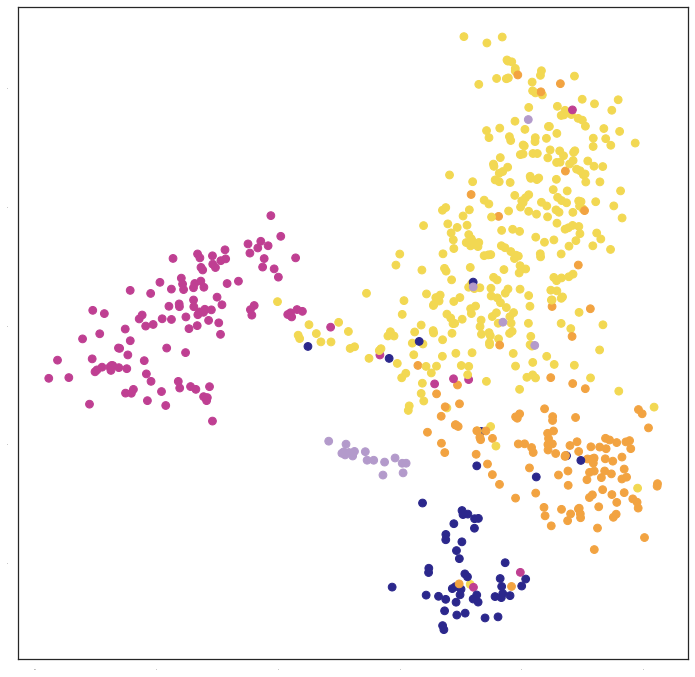

In [39]:
#UMAP of learened feature
mapper = umap.UMAP(
    random_state=111,
    n_epochs=10,
    n_components=2,
    n_neighbors=20,metric='euclidean',output_metric='euclidean',learning_rate=1.0,
    init='spectral',min_dist=0.9,spread=0.9,n_jobs=-1,
    set_op_mix_ratio=1.0,local_connectivity=1.0,repulsion_strength=1.0,
    negative_sample_rate=5,transform_queue_size=4.0,target_n_neighbors=-1,
    target_metric='categorical',target_weight=0.5,transform_seed=42,
    transform_mode='embedding',dens_lambda=2.0,dens_frac=0.3,
    dens_var_shift=0.1).fit(latent_Z)

scaled_data = StandardScaler().fit_transform(latent_Z)
embedding = mapper.fit_transform(scaled_data)
x_min, x_max = np.min(embedding, 0), np.max(embedding, 0)
embedding = embedding / (x_max - x_min)
index = pd.read_csv('/Users/solomon/Desktop/BRCA/BRCA_label_num.csv', header=0)
index = index[0 :data_num].astype(int)
label = index.values.tolist()  #list
plt.figure(figsize=(12, 12)) 
sns.set(style='white',context='notebook')
my_color = ["#BF3F92","#2B278C","#F2D852","#F2A341","#B39ACB"]
my_cmap = ListedColormap(sns.color_palette(my_color).as_hex())
a = plt.scatter(embedding[:, 0], embedding[:, 1], marker='o', cmap=my_cmap,c=label,s=60)

plt.xlabel("", size=24)  
plt.ylabel("", size=24)
plt.tick_params(axis='x', which='both', labelsize=0)
plt.tick_params(axis='y', which='both', labelsize=0)

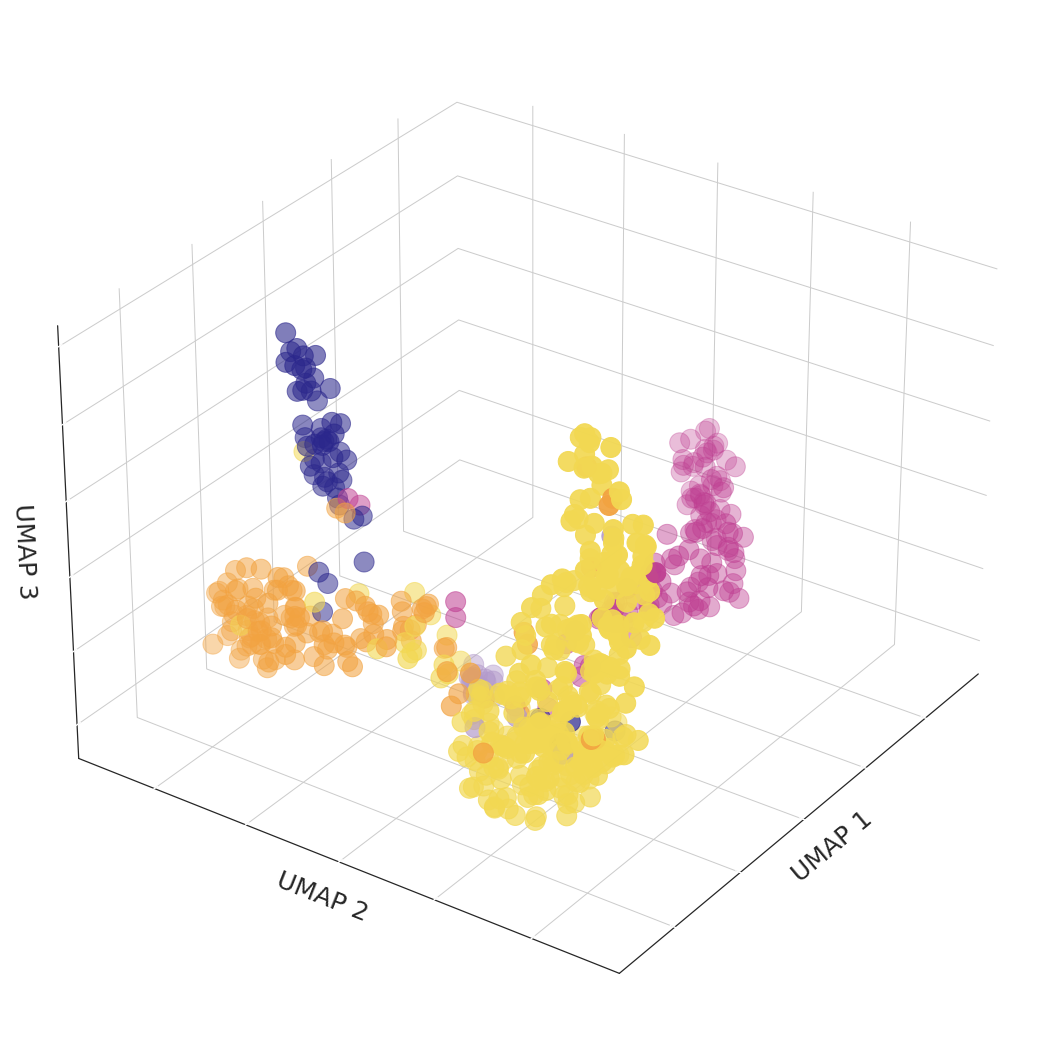

In [44]:
#3D-UMAP
mapper = umap.UMAP(
    random_state=111,
    n_epochs=100,
    n_components=3,
    n_neighbors=20,metric='euclidean',output_metric='euclidean',learning_rate=1.0,
    init='spectral',min_dist=0.9,spread=0.9,n_jobs=-1,
    set_op_mix_ratio=1.0,local_connectivity=1.0,repulsion_strength=1.0,
    negative_sample_rate=5,transform_queue_size=4.0,target_n_neighbors=-1,
    target_metric='categorical',target_weight=0.5,transform_seed=42,
    transform_mode='embedding',dens_lambda=2.0,dens_frac=0.3,
    dens_var_shift=0.1).fit(latent_Z)

scaled_data = StandardScaler().fit_transform(latent_Z)
embedding = mapper.fit_transform(scaled_data)
x_min, x_max = np.min(embedding, 0), np.max(embedding, 0)
embedding = embedding / (x_max - x_min)

fig = plt.figure(1, figsize=(15, 15))
ax = fig.add_subplot(111, projection="3d", elev=30, azim=35)
ax.set_position([0, 0, 0.95, 1])
ax.set_axis_off() 
plt.gca().patch.set_facecolor('white')
plt.grid(visible=None)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

plt.cla()

my_color = ["#BF3F92","#2B278C","#F2D852","#F2A341","#B39ACB"]
my_cmap = ListedColormap(sns.color_palette(my_color).as_hex())
a = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=index, cmap=my_cmap,s=400)


ax.set_xlabel('UMAP 1',size = 25)
ax.set_ylabel('UMAP 2',size = 25)
ax.set_zlabel('UMAP 3',size = 25)

plt.tick_params(
    axis='both',which='both',color= 'w',
    labelbottom=False,labeltop=False,labelleft=False,labelright=False
)